# Ising model

In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as scila
import matplotlib.pyplot as plt

## Adjacency matrices for various lattices

In [2]:
def adjacency_1D_lattice(L, pbc=True):
    """
    Construct the adjacency matrix for a 1D lattice with `L` sites.
    The optional parameter `pbc` specifies whether periodic boundary conditions
    should be used.
    """
    assert L > 1
    # special case
    if L == 2:
        return np.array([[0, 1], [1, 0]])
    if pbc:
        # periodic boundary conditions
        return np.roll(np.identity(L, dtype=int), -1, axis=0) + np.roll(np.identity(L, dtype=int), 1, axis=0)
    else:
        # open boundary conditions
        return np.diag(np.ones(L - 1, dtype=int), k=-1) + np.diag(np.ones(L - 1, dtype=int), k=1)

In [3]:
# should be symmetric
np.linalg.norm(adjacency_1D_lattice(7) - adjacency_1D_lattice(7).T)

0.0

In [4]:
# each site should have 2 neighbors (for periodic boundary conditions)
np.sum(adjacency_1D_lattice(7), axis=0)

array([2, 2, 2, 2, 2, 2, 2])

In [5]:
# test for periodic boundary conditions (difference should be zero)
np.linalg.norm(adjacency_1D_lattice(7) - np.array(
    [[0, 1, 0, 0, 0, 0, 1],
     [1, 0, 1, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 1, 0],
     [0, 0, 0, 0, 1, 0, 1],
     [1, 0, 0, 0, 0, 1, 0]]))

0.0

In [6]:
# test for open boundary conditions (difference should be zero)
np.linalg.norm(adjacency_1D_lattice(7, pbc=False) - np.array(
    [[0, 1, 0, 0, 0, 0, 0],
     [1, 0, 1, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 1, 0],
     [0, 0, 0, 0, 1, 0, 1],
     [0, 0, 0, 0, 0, 1, 0]]))

0.0

In [7]:
def adjacency_square_lattice(Lx, Ly, pbc=True):
    """
    Construct the adjacency matrix for a 2D square lattice with `Lx x Ly` sites.
    The optional parameter `pbc` specifies whether periodic boundary conditions
    should be used.
    """
    assert Lx > 1 and Ly > 1
    L = Lx * Ly
    adj = np.zeros((L, L), dtype=int)
    # enumerate lattice sites
    idx = np.arange(L).reshape((Lx, Ly))
    if pbc:
        # periodic boundary conditions
        # loop over directions (x- and y-direction)
        for a in range(2):
            # loop over "left" or "right" neighbor
            for s in [-1, 1]:
                ids = np.roll(idx, s, axis=a)
                for (i, j) in zip(idx.reshape(-1), ids.reshape(-1)):
                    adj[i, j] = 1
    else:
        # open boundary conditions
        for x in range(Lx):
            for y in range(Ly):
                # nearest neighbors
                if x > 0:
                    adj[idx[x, y], idx[x - 1, y]] = 1
                if x + 1 < Lx:
                    adj[idx[x, y], idx[x + 1, y]] = 1
                if y > 0:
                    adj[idx[x, y], idx[x, y - 1]] = 1
                if y + 1 < Ly:
                    adj[idx[x, y], idx[x, y + 1]] = 1
    return adj

In [8]:
# should be symmetric
np.linalg.norm(adjacency_square_lattice(3, 4) - adjacency_square_lattice(3, 4).T)

0.0

In [9]:
# each site should have 4 neighbors (for periodic boundary conditions)
np.sum(adjacency_square_lattice(3, 4), axis=0)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [10]:
# test for periodic boundary conditions (difference should be zero)
np.linalg.norm(adjacency_square_lattice(3, 4) - np.array(
    [[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
     [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
     [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
     [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
     [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1],
     [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
     [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
     [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]]))

0.0

In [11]:
# test for open boundary conditions (difference should be zero)
np.linalg.norm(adjacency_square_lattice(3, 4, pbc=False) - np.array(
    [[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
     [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]]))

0.0

## Ising Hamiltonian construction

In [12]:
def construct_ising_hamiltonian(J, g, adj):
    """
    Construct Ising Hamiltonian as sparse matrix,
    for interaction parameter `J` and external field parameter `g`.
    `adj` is the adjacency matrix of the underlying lattice.
    """
    # Pauli-X and Z matrices
    X = sparse.csr_matrix([[0., 1.], [1.,  0.]])
    Z = sparse.csr_matrix([[1., 0.], [0., -1.]])
    # overall number of lattice sites
    L = adj.shape[0]
    H = sparse.csr_matrix((2**L, 2**L), dtype=float)
    for j in range(L):
        for k in range(j+1, L):
            if adj[j, k] > 0:
                H -= J * sparse.kron(sparse.eye(2**j),
                         sparse.kron(Z,
                         sparse.kron(sparse.eye(2**(k-j-1)),
                         sparse.kron(Z,
                                     sparse.eye(2**(L-k-1))))))
    # external field
    for j in range(L):
        H -= g * sparse.kron(sparse.eye(2**j), sparse.kron(X, sparse.eye(2**(L-j-1))))
    return H

In [13]:
# example
adj = adjacency_1D_lattice(3, pbc=False)
H = construct_ising_hamiltonian(1.1, 0.7, adj)
H

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [14]:
# convert to NumPy array to show entries
H.toarray()

array([[-2.2, -0.7, -0.7,  0. , -0.7,  0. ,  0. ,  0. ],
       [-0.7,  0. ,  0. , -0.7,  0. , -0.7,  0. ,  0. ],
       [-0.7,  0. ,  2.2, -0.7,  0. ,  0. , -0.7,  0. ],
       [ 0. , -0.7, -0.7,  0. ,  0. ,  0. ,  0. , -0.7],
       [-0.7,  0. ,  0. ,  0. ,  0. , -0.7, -0.7,  0. ],
       [ 0. , -0.7,  0. ,  0. , -0.7,  2.2,  0. , -0.7],
       [ 0. ,  0. , -0.7,  0. , -0.7,  0. ,  0. , -0.7],
       [ 0. ,  0. ,  0. , -0.7,  0. , -0.7, -0.7, -2.2]])

In [15]:
# test: this should give zero
np.linalg.norm(H - np.array(
    [[-2.2, -0.7, -0.7,  0. , -0.7,  0. ,  0. ,  0. ],
     [-0.7,  0. ,  0. , -0.7,  0. , -0.7,  0. ,  0. ],
     [-0.7,  0. ,  2.2, -0.7,  0. ,  0. , -0.7,  0. ],
     [ 0. , -0.7, -0.7,  0. ,  0. ,  0. ,  0. , -0.7],
     [-0.7,  0. ,  0. ,  0. ,  0. , -0.7, -0.7,  0. ],
     [ 0. , -0.7,  0. ,  0. , -0.7,  2.2,  0. , -0.7],
     [ 0. ,  0. , -0.7,  0. , -0.7,  0. ,  0. , -0.7],
     [ 0. ,  0. ,  0. , -0.7,  0. , -0.7, -0.7, -2.2]]))

0.0

## Exemplary eigenvalues and -vectors

In [16]:
L = 10
J = 1.0
g = 0.8
adj = adjacency_1D_lattice(L)
H = construct_ising_hamiltonian(J, g, adj)
H

<1024x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 11264 stored elements in Compressed Sparse Row format>

In [38]:
# compute algebraically smallest few eigenvalues and corresponding eigenvectors
en, ψ = scila.eigsh(H, k=5, which='SA')
print(en)

[-25.5251383  -23.52499336 -23.04636601 -23.04636601 -22.06089175]


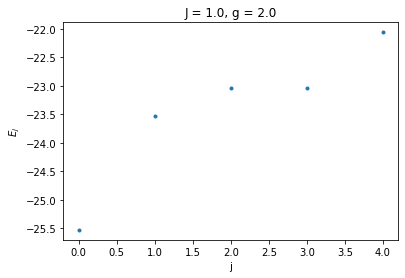

In [35]:
# visualize these eigenvalues
plt.plot(en, '.')
plt.xlabel("j")
plt.ylabel(r"$E_j$")
plt.title("J = {}, g = {}".format(J, g))
plt.show()

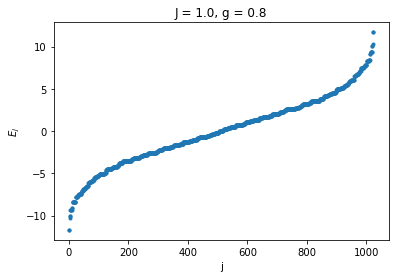

In [19]:
# for comparison: plot full spectrum
plt.plot(np.linalg.eigvalsh(H.toarray()), '.')
plt.xlabel("j")
plt.ylabel(r"$E_j$")
plt.title("J = {}, g = {}".format(J, g))
plt.show()

## Spin-spin correlation function

In [20]:
J = 1.0

# Pauli-Z matrix
Z = sparse.csr_matrix([[1., 0.], [0., -1.]])

Llist = np.array([6, 8, 10, 12])
glist = np.linspace(0, 2, 21)

C = np.zeros((len(Llist), len(glist)))

# iterate over various lattice sizes
for i, L in enumerate(Llist):
    print("L =", L)
    # spin operators (Pauli-Z) on site 0 and center site L/2
    Z0 = sparse.kron(Z, sparse.eye(2**(L-1)))
    Zc = sparse.kron(sparse.eye(2**(L//2)), sparse.kron(Z, sparse.eye(2**(L-L//2-1))))
    adj = adjacency_1D_lattice(L)
    # parameter sweep over `g`
    for j, g in enumerate(glist):
        H = construct_ising_hamiltonian(J, g, adj)
        en, ψ = scila.eigsh(H, k=5, which='SA')
        # ground state
        ψ0 = ψ[:, 0]
        # spin-spin correlation function
        C[i, j] = np.vdot(ψ0, Z0 @ (Zc @ ψ0))

L = 6
L = 8
L = 10
L = 12


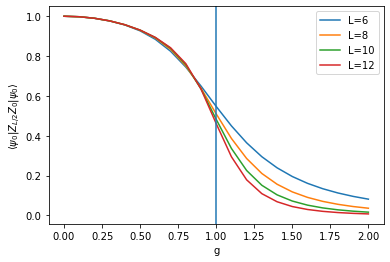

In [21]:
# visualize correlation function
for i, L in enumerate(Llist):
    plt.plot(glist, C[i, :], label="L={}".format(L))
# Ising model exhibits a phase transition at g = 1 in the thermodynamic limit L -> ∞
plt.axvline(x=1)
plt.legend()
plt.xlabel("g")
plt.ylabel(r"$\langle\psi_0|Z_{L/2} Z_0|\psi_0\rangle$")
plt.show()

## Excitation energies

In [22]:
J = 1.0

Llist = np.array([10, 12])
glist = np.linspace(0, 2, 21)

# excitation energies
exc1 = np.zeros((len(Llist), len(glist)))
exc2 = np.zeros((len(Llist), len(glist)))

# iterate over various lattice sizes
for i, L in enumerate(Llist):
    print("L =", L)
    adj = adjacency_1D_lattice(L)
    # parameter sweep over `g`
    for j, g in enumerate(glist):
        H = construct_ising_hamiltonian(J, g, adj)
        en, ψ = scila.eigsh(H, k=5, which='SA')
        en = np.sort(en)
        exc1[i, j] = en[1] - en[0]
        exc2[i, j] = en[2] - en[0]

L = 10
L = 12


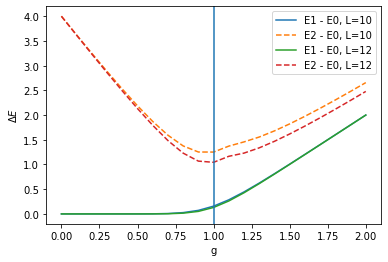

In [23]:
# visualize excitation energies
for i, L in enumerate(Llist):
    plt.plot(glist, exc1[i, :],       label="E1 - E0, L={}".format(L))
    plt.plot(glist, exc2[i, :], '--', label="E2 - E0, L={}".format(L))
# Ising model exhibits a phase transition at g = 1 in the thermodynamic limit L -> ∞
# Here we see that a "gap" opens at g = 1, i.e., E1 - E0 remains strictly positive for g > 1.
plt.axvline(x=1)
plt.legend()
plt.xlabel("g")
plt.ylabel(r"$\Delta E$")
plt.show()